In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model# Load the model in HDF5 format

In [ ]:
model = load_model('cifar10.h5')
model.get_config()

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

def plot_image(predictions_array, img, true_label=None):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)

    accuracy = f" ({labels[int(true_label)]})" if true_label != None else ""
    if predicted_label == true_label and true_label != None:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}%{accuracy}",
               color=color)

def plot_value_array(predictions_array, true_label=None):
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    if true_label != None: thisplot[int(true_label)].set_color('blue')

1/1 [==============================] - 0s 311ms/step


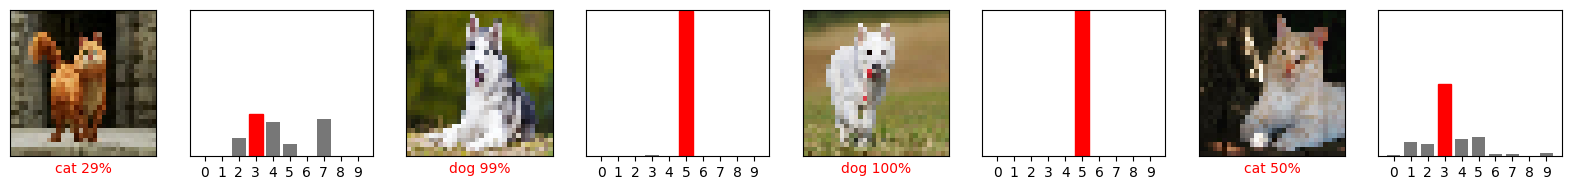

Image 1: Predicted Class - cat
Image 2: Predicted Class - dog
Image 3: Predicted Class - dog
Image 4: Predicted Class - cat


In [ ]:
import requests
from PIL import Image
import cv2

def get_img(url):
  r = requests.get(url, stream=True)  # Download
  img = np.array(Image.open(r.raw))  # Convert to NP Array
  img = cv2.resize(img, (32, 32))  # Resize to match VGG16 input
  return img / 255.0

# Define a list of image URLs
urls = [
    "https://apahabar.s3.ap-southeast-1.amazonaws.com/storage/20230619/080950-garfield-webp-large.webp",
    "https://www.blibli.com/friends-backend/wp-content/uploads/2023/03/B300224-Cover-Fakta-Anjing-Husky-scaled.jpg",
    "https://cdn0-production-images-kly.akamaized.net/NIyhdKW2Oh7XNUU_s_KVjM74qE8=/1200x1200/smart/filters:quality(75):strip_icc():format(webp)/kly-media-production/medias/1053303/original/025149900_1447383884-13112015-anjing.jpg",
    "https://img.okezone.com/okz/500/content/2023/10/11/406/2898966/apakah-kucing-boleh-makan-tempe-berikut-penjelasannya-AUJSwpViXv.JPG"
]

imgs = []

# Loop through the URLs, download, preprocess, and classify the images
for u in range(0, len(urls)):
    img = get_img(urls[u])
    imgs.append(img)  # Collect all preprocessed images into imgs

imgs = np.array(imgs)  # Convert to Np Array

# Perform classification on the downloaded and preprocessed images
predictions = model.predict(imgs)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 1
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(predictions[i], imgs[i])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[i])
plt.tight_layout()
plt.show()

# Define class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loop through the results and print the predicted class labels
for i in range(len(urls)):
    predicted_class_index = np.argmax(predictions[i])
    predicted_class = class_labels[predicted_class_index]
    print(f"Image {i + 1}: Predicted Class - {predicted_class}")

In [ ]:
# url = input("Masukan url: ")
# r = requests.get(url, stream=True)  # Download
# img = np.array(Image.open(r.raw))  # Convert to NP Array
# plt.imshow(img)
# plt.show()
# print("\n")
# img = get_img(url)
# predict = model.predict(np.array([img]))
# plt.figure(figsize=(4, 2))
# plt.subplot(1, 2, 1)
# plot_image(predict, img)
# plt.subplot(1, 2, 2)
# plot_value_array(predict[0])
# plt.tight_layout()
# plt.show()

In [ ]:
!pip install -U tf2onnx



In [ ]:
import shutil
import tf2onnx
onnx_model, _ = tf2onnx.convert.from_saved_model(model)
tf2onnx.save_model(onnx_model, 'output_model.onnx')
# keras.models.save_model(model, 'keras/model', save_format='tf')
# shutil.make_archive('keras_model', 'zip', 'keras/model')

In [ ]:
import tensorflow as tf

# Load the SavedModel
model_path = 'keras/model/'
loaded_model = tf.saved_model.load(model_path)

# Print the signature keys (input and output names)
signature_keys = list(loaded_model.signatures.keys())
print("Signature Keys:", signature_keys)

# Use one of the signature keys to get the concrete function
signature_key = signature_keys[0]  # Use an appropriate key based on your model
concrete_function = loaded_model.signatures[signature_key]

# Get the input and output tensor names
input_tensor_names = [tensor.name for tensor in concrete_function.inputs]
output_tensor_names = [tensor.name for tensor in concrete_function.outputs]

print("Input Tensor Names:", input_tensor_names)
print("Output Tensor Names:", output_tensor_names)


In [ ]:
# Konversi ke TensorFlow Graph
@tf.function
def forward_pass(inputs):
    return model(inputs)

concrete_func = forward_pass.get_concrete_function(tf.TensorSpec(shape=(None,) + model.input_shape[1:], dtype=tf.float32))

# Simpan model sebagai SavedModel
tf.saved_model.save(model, 'saved_model', signatures={'serving_default': concrete_func})

In [ ]:
from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

input_saved_model_dir = 'saved_model'
output_node_names = 'output_dense_2'  # Sesuaikan dengan nama node output model Anda
output_frozen_graph = 'cifar10.pb'

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="Placeholder"))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

### USAGE ##
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    print("-" * 50)
    print("Frozen model layers: ")
    layers = [op.name for op in import_graph.get_operations()]
    if print_graph == True:
        for layer in layers:
            print(layer)
    print("-" * 50)

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))

## Example Usage ###
# Load frozen graph using TensorFlow 1.x functions
with tf.io.gfile.GFile("./frozen_models/frozen_graph.pb", "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    loaded = graph_def.ParseFromString(f.read())

# Wrap frozen graph to ConcreteFunctions
frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                inputs=["Placeholder:0"],
                                outputs=["Identity:0"],
                                print_graph=True)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Get predictions for test images
predictions = frozen_func(Placeholder=tf.constant([[3.]]))
# Print the prediction for the first image
print("-" * 50)
print("Example prediction reference:")
print(predictions[0].numpy())

--------------------------------------------------
Frozen model layers: 
Placeholder
sequential/conv2d/Conv2D/ReadVariableOp/resource
sequential/conv2d/BiasAdd/ReadVariableOp/resource
sequential/batch_normalization/ReadVariableOp/resource
sequential/batch_normalization/ReadVariableOp_1/resource
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp/resource
sequential/batch_normalization/FusedBatchNormV3/ReadVariableOp_1/resource
sequential/conv2d_1/Conv2D/ReadVariableOp/resource
sequential/conv2d_1/BiasAdd/ReadVariableOp/resource
sequential/batch_normalization_1/ReadVariableOp/resource
sequential/batch_normalization_1/ReadVariableOp_1/resource
sequential/batch_normalization_1/FusedBatchNormV3/ReadVariableOp/resource
sequential/batch_normalization_1/FusedBatchNormV3/ReadVariableOp_1/resource
sequential/conv2d_2/Conv2D/ReadVariableOp/resource
sequential/conv2d_2/BiasAdd/ReadVariableOp/resource
sequential/batch_normalization_2/ReadVariableOp/resource
sequential/batch_normalizatio

InvalidArgumentError: ignored

In [ ]:
!bazel build tensorflow/python/tools:freeze_graph && \

/bin/bash: line 1: bazel: command not found
